In [ ]:
pip install transformers datasets torch gdown matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_

In [ ]:
pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Correct path to your CSV file
csv_file_path = '/content/drive/My Drive/ner_datasetreferenc.csv'

# Try reading the CSV file with different encodings
df = None
encodings = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings:
    try:
        df = pd.read_csv(csv_file_path, encoding=encoding)
        print(f"Successfully read the file with encoding: {encoding}")
        break
    except UnicodeDecodeError as e:
        print(f"Failed to read the file with encoding {encoding}: {e}")



Failed to read the file with encoding utf-8: 'utf-8' codec can't decode byte 0x85 in position 0: invalid start byte
Successfully read the file with encoding: latin1


In [ ]:
import pandas as pd
from datasets import Dataset


# Preprocess dataset
df = df.fillna(method='ffill')

# Ensure 'Sentence #' column is consistently formatted
def process_sentence_number(x):
    if isinstance(x, str) and "Sentence: " in x:
        try:
            return int(x.split(": ")[1])
        except ValueError:
            return None
    try:
        return int(x)
    except ValueError:
        return None

df['Sentence #'] = df['Sentence #'].apply(process_sentence_number)

# Drop any rows where 'Sentence #' could not be converted
df = df.dropna(subset=['Sentence #'])

# Convert 'Sentence #' to integer
df['Sentence #'] = df['Sentence #'].astype(int)

# Map tags to integers
tag2id = {tag: id for id, tag in enumerate(df['Tag'].unique())}
df['Tag'] = df['Tag'].map(tag2id)

# Group the data by 'Sentence #' and create lists of tokens and tags
grouped = df.groupby('Sentence #').agg({'Word': lambda x: list(x), 'Tag': lambda x: list(x)}).reset_index()

# Convert to Hugging Face dataset
data = {'tokens': grouped['Word'], 'ner_tags': grouped['Tag']}
dataset = Dataset.from_dict(data)


In [ ]:
from datasets import DatasetDict
from transformers import RobertaTokenizerFast

# Train-test split
train_test_split = dataset.train_test_split(test_size=0.2)
datasets = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

# Load tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True)

# Tokenize the dataset
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], padding='max_length', truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/38367 [00:00<?, ? examples/s]

Map:   0%|          | 0/9592 [00:00<?, ? examples/s]

In [ ]:
from transformers import RobertaForTokenClassification, Trainer, TrainingArguments
import torch

# Clear CUDA cache
torch.cuda.empty_cache()

# Load model
model = RobertaForTokenClassification.from_pretrained('roberta-base', num_labels=len(tag2id))

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()

# Set per-process memory fraction for better memory management
torch.cuda.set_per_process_memory_fraction(0.8)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Further reduce batch size to save memory
    per_device_eval_batch_size=8,   # Further reduce eval batch size to save memory
    num_train_epochs=3,
    weight_decay=0.05,
    fp16=True,  # Enable mixed precision training
    gradient_accumulation_steps=2,  # Accumulate gradients to effectively increase batch size
    max_grad_norm=1.0,  # Clip gradients to prevent exploding gradients
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
)

# Train the model
trainer.train()


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=7194, training_loss=0.09904311065843512, metrics={'train_runtime': 4787.4722, 'train_samples_per_second': 24.042, 'train_steps_per_second': 1.503, 'total_flos': 3.0079596660857856e+16, 'train_loss': 0.09904311065843512, 'epoch': 3.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()

print("Evaluation results:")
print(results)


Evaluation results:
{'eval_loss': 0.0876154899597168, 'eval_runtime': 80.7149, 'eval_samples_per_second': 118.838, 'eval_steps_per_second': 14.855, 'epoch': 3.0}


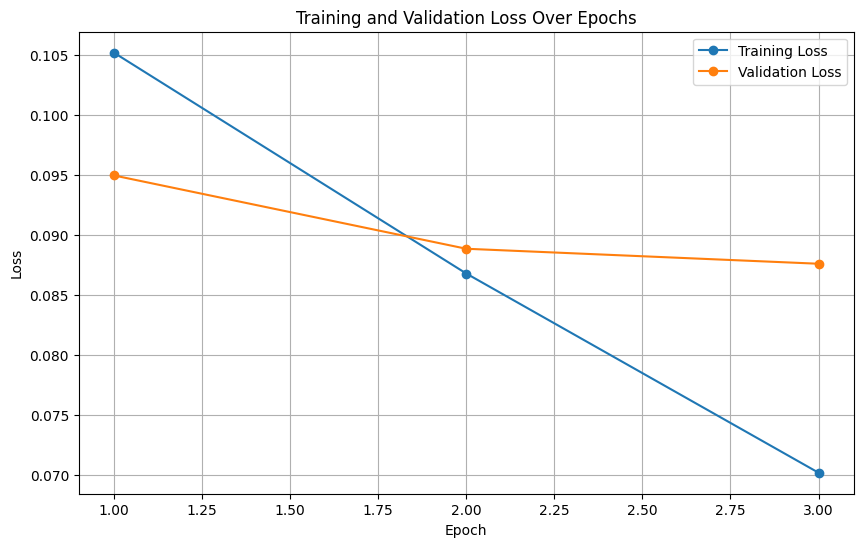

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = [1, 2, 3]
training_loss = [0.105200, 0.086800, 0.070200]
validation_loss = [0.094972, 0.088864, 0.087615]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
